In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import numpy as np
import pandas as pd
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
from sklearn.linear_model import LinearRegression
import pickle

In [2]:
import pickle
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns

In [3]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 

In [4]:
grid = sc.read_h5ad(os.path.join(pathout, "grid_save.h5ad"))
grid

AnnData object with n_obs × n_vars = 35389 × 1500
    obs: 'imagecol', 'imagerow', 'n_cells', 'cluster'
    obsm: '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spatial', 'spot_neigh_bcs', 'spot_neighbours'

In [5]:
from scipy.sparse import csr_matrix
grid.X = csr_matrix(grid.X)

In [6]:
import os
import pickle

file_path = os.path.join(pathout, "grid_uns_mtracies.pkl")

if os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as buff:
        grid_uns_mtracies = pickle.load(buff)
else:
    print("File is empty. Cannot load data.")
    grid_uns_mtracies = None

In [7]:
grid_uns_mtracies.keys()

dict_keys(['grid_counts', 'grid_xedges', 'grid_yedges'])

In [8]:
grid.uns = {}
grid.uns['cluster'] = pd.read_csv(os.path.join(pathout, "cluster.csv"))
grid.uns['grid_counts'] = grid_uns_mtracies['grid_counts']
grid.uns['grid_xedges'] = grid_uns_mtracies['grid_xedges']
grid.uns['grid_yedges'] = grid_uns_mtracies['grid_yedges']
grid.uns['lrfeatures'] = pd.read_csv(os.path.join(pathout, "lrfeatures.csv"))
grid.uns['lr_summary'] = pd.read_csv(os.path.join(pathout, "lr_summary.csv"))

In [9]:
grid

AnnData object with n_obs × n_vars = 35389 × 1500
    obs: 'imagecol', 'imagerow', 'n_cells', 'cluster'
    uns: 'cluster', 'grid_counts', 'grid_xedges', 'grid_yedges', 'lrfeatures', 'lr_summary'
    obsm: '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spatial', 'spot_neigh_bcs', 'spot_neighbours'

<center><h3> Moran scatter plot</center>

"the x-axis is the value of a variable at each
cell, and the y-axis is the spatially lagged value (i.e. sum of values from spatial neighbors
weighted by edge weights of the spatial neighborhood graph). When the adjacency matrix of the spatial neighborhood graph is row normalized, it is shown in Anselin 199612 that the slope of the line fitted to the scatter plot is global Moran’s I, while the scatter plot shows local heterogeneity in spatial autocorrelation."
Lior Pachter

Adding ```n_counts``` variable for preforming spatial statstics on library size cell leval

In [10]:
sparse_matrix = grid.X
row_sums = sparse_matrix.sum(axis=1)
grid.obs['n_counts'] = np.array(row_sums).flatten()
grid

AnnData object with n_obs × n_vars = 35389 × 1500
    obs: 'imagecol', 'imagerow', 'n_cells', 'cluster', 'n_counts'
    uns: 'cluster', 'grid_counts', 'grid_xedges', 'grid_yedges', 'lrfeatures', 'lr_summary'
    obsm: '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spatial', 'spot_neigh_bcs', 'spot_neighbours'

In [11]:
grid.uns['cluster']
cell_id_list = grid.uns['cluster'].iloc[:,0].tolist()
grid.uns['cluster'].index = cell_id_list
grid.uns['cluster'] = grid.uns['cluster'].iloc[:,1:]

build a wight object to the libpysal librarey by genreating a dictonery like in the example. 
https://pysal.org/libpysal/generated/libpysal.weights.W.html

```python
from libpysal.weights import W
neighbors = {0: [3, 1], 1: [0, 4, 2], 2: [1, 5], 3: [0, 6, 4], 4: [1, 3, 7, 5], 5: [2, 4, 8], 6: [3, 7], 7: [4, 6, 8], 8: [5, 7]}
weights = {0: [1, 1], 1: [1, 1, 1], 2: [1, 1], 3: [1, 1, 1], 4: [1, 1, 1, 1], 5: [1, 1, 1], 6: [1, 1], 7: [1, 1, 1], 8: [1, 1]}
w = W(neighbors, weights)
```

In [12]:
arr = grid.obs['cluster'].to_numpy().astype(int)

In [13]:
neighbors = {}
weights = {}
for i,a in enumerate(arr):
    neighbors[i] = np.where(arr == a)[0].tolist()
    if i in neighbors[i]:
        neighbors[i].remove(i)
    weights[i] = [1] * len(neighbors[i])


In [14]:
len(neighbors.keys())

35389

In [ ]:
weights

In [42]:
from libpysal.weights import W
w = W(neighbors, weights)

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
  warnings.warn(message)


In [43]:
w.sparse

<35389x35389 sparse matrix of type '<class 'numpy.int64'>'
	with 162538570 stored elements in Compressed Sparse Row format>

Available Transformations:
'r' (Row-standardization): This transformation standardizes the weights by dividing each weight by the sum of the weights in the corresponding row. This means that the sum of the weights for each observation (row) will be 1. Row-standardization is commonly used in spatial statistics to ensure comparability of spatial weights across different observations, especially when dealing with varying numbers of neighbors.
Example:
When you set w.transform = 'r', you're instructing pysal to apply row-standardization to the weights matrix. After this transformation, each row in the weights matrix will sum to 1, making it a row-normalized weights matrix.

This is useful in many spatial statistical analyses because it ensures that each observation has the same influence regardless of the number of neighbors.

Practical Impact:
If you had a row in the weights matrix with weights [0.5, 1.5, 2.0], applying w.transform = 'r' would change these weights to [0.125, 0.375, 0.5], where each value is the original weight divided by the sum of the weights in that row (0.5 + 1.5 + 2.0 = 4.0).

In [17]:
w.transform = 'r'

In [45]:
grid.obs['n_counts'].values

array([23.32867432, 79.39700139, 34.94170427, ..., 61.22941542,
       49.97226727, 53.4674983 ])

In [41]:
w.sparse

<35389x35389 sparse matrix of type '<class 'numpy.float64'>'
	with 162538570 stored elements in Compressed Sparse Row format>

In [46]:
n_counts = grid.obs['n_counts'].values
n_counts_lag = lps.weights.lag_spatial(w, n_counts)
x = grid.obsm['spatial'][:, 0]
y =  grid.obsm['spatial'][:, 1]
clusters = grid.obs['cluster'].values
df  = pd.DataFrame({'cluster':clusters,"x":x,"y":y,"n_counts":n_counts,"n_counts_lag":n_counts_lag})

In [47]:
import pickle
file_path = os.path.join(pathout, "andata_uns_mtracies.pkl")
with open(file_path, 'rb') as buff:
    andata_uns_mtracies = pickle.load(buff)
clusterColorMap = andata_uns_mtracies['clusterColorMap']
clusterColorMap

,clusters,colors
0,6,"(0.7725490196078432, 0.6901960784313725, 0.835..."
1,11,"(0.7764705882352941, 0.8588235294117647, 0.937..."
2,9,"(0.4588235294117647, 0.4196078431372549, 0.694..."
3,1,"(0.9921568627450981, 0.5529411764705883, 0.235..."
4,10,"(0.17254901960784313, 0.6274509803921569, 0.17..."
5,5,"(0.5176470588235295, 0.23529411764705882, 0.22..."
6,3,"(1.0, 0.7333333333333333, 0.47058823529411764,..."
7,7,"(0.3215686274509804, 0.32941176470588235, 0.63..."
8,0,"(0.807843137254902, 0.42745098039215684, 0.741..."
9,4,"(0.7803921568627451, 0.9137254901960784, 0.752..."


In [48]:
df

,cluster,x,y,n_counts,n_counts_lag
0,9,216.268,3294.550,23.328674,2.821190e+06
1,11,216.268,3351.982,79.397001,3.194365e+05
2,11,216.268,3380.698,34.941704,3.194810e+05
3,10,216.268,3409.414,72.192883,4.148494e+06
4,6,216.268,3581.710,25.032505,4.981620e+06
...,...,...,...,...,...
35384,7,8317.732,4873.930,47.632877,1.417281e+06
35385,5,8317.732,4960.078,119.062455,1.553864e+06
35386,5,8317.732,5017.510,61.229415,1.553922e+06
35387,5,8317.732,5046.226,49.972267,1.553934e+06


<Axes: xlabel='n_counts', ylabel='n_counts_lag'>

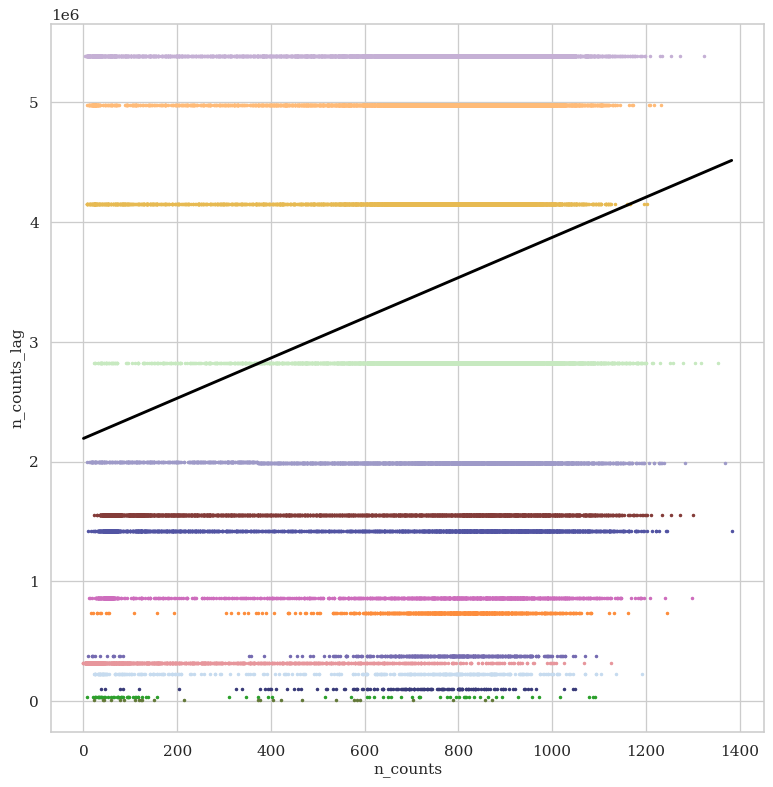

In [49]:
clusters = sorted(np.unique(df['cluster'].values), key=int)
sns.set_theme(style="whitegrid")
palette = clusterColorMap.sort_index()['colors'].to_list()
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, cluster in enumerate(clusters):
    cluster_grid = df[df['cluster'] == cluster]
    ax.scatter(x=cluster_grid['n_counts'], y=cluster_grid['n_counts_lag'], color=palette[i], label=f'{cluster}', s=3, alpha=1)
sns.regplot(data=df, x=df['n_counts'], y=df['n_counts_lag'],color= 'black',scatter_kws={'s': 0},ci = None,ax= ax)
# ax.set_ylabel(" Response Element (std) ")
# ax.set_xlabel("H0 (std)")
# ax.set_title(title)

<center>Attribute Similarity

So the spatial weight between neighborhoods and indicates if the two are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us. For neighborhood 
 the spatial lag is defined as:

$
ylog_i = \sum_j(w_i,jy_j)
$
 

Lets try to use the LR results from the stLEarn anlysis:
BTLA CD79A

In [202]:
ligand_values = grid.X[:,grid.var_names=="BTLA"].toarray()
ligand_values = np.nan_to_num(ligand_values, nan=0.0)
receptor_values = grid.X[:,grid.var_names=="CD79A"].toarray()
receptor_values = np.nan_to_num(receptor_values, nan=0.0)
clusters = grid.obs['cluster'].values
x = grid.obsm['spatial'][:, 0]
y =  grid.obsm['spatial'][:, 1]

In [203]:
def plot_dist(arr,ax,type = 'obs', bins = 'auto',title = '',xlab = '',ylab ='',color_ = 'red'):
    '''
    You can replace 'auto' with any other method (e.g., 'fd', 'doane', 'scott', 'rice', 'sturges', or 'sqrt')
    '''
    arr = arr[~np.isnan(arr)]
    palette1 = sns.color_palette("colorblind",9)
    bin_edges = np.histogram_bin_edges(arr, bins='auto')
    # Calculate bin edges using NumPy's 'auto' method
    # Calculate bin width
    bin_width = bin_edges[1] - bin_edges[0]
    sns.histplot(arr, binwidth=bin_width, palette=color_, kde=True,  ax=ax)
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
    ax.set_title(title) 

In [204]:
sns.color_palette("colorblind",9)[0]

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)

/tmp/ipykernel_1884966/2130770872.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(arr, binwidth=bin_width, palette=color_, kde=True,  ax=ax)
/tmp/ipykernel_1884966/2130770872.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(arr, binwidth=bin_width, palette=color_, kde=True,  ax=ax)


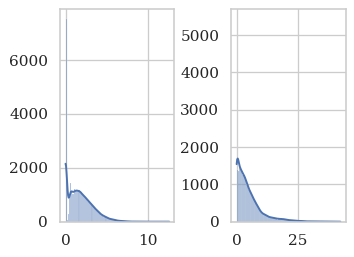

In [205]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, axes = plt.subplots(1, 2, figsize=(4, 3))
plot_dist(arr = ligand_values,ax= axes[0], color_ = sns.color_palette("colorblind",9)[0])
plot_dist(arr = receptor_values,ax= axes[1], color_ = sns.color_palette("colorblind",9)[1])
plt.subplots_adjust(wspace = 0.5, hspace=0.5)

In [206]:
w.sparse

<35389x35389 sparse matrix of type '<class 'numpy.int64'>'
	with 162538570 stored elements in Compressed Sparse Row format>

In [208]:
ligand_values_lag = lps.weights.lag_spatial(w, ligand_values)
receptor_values_lag = lps.weights.lag_spatial(w, receptor_values)

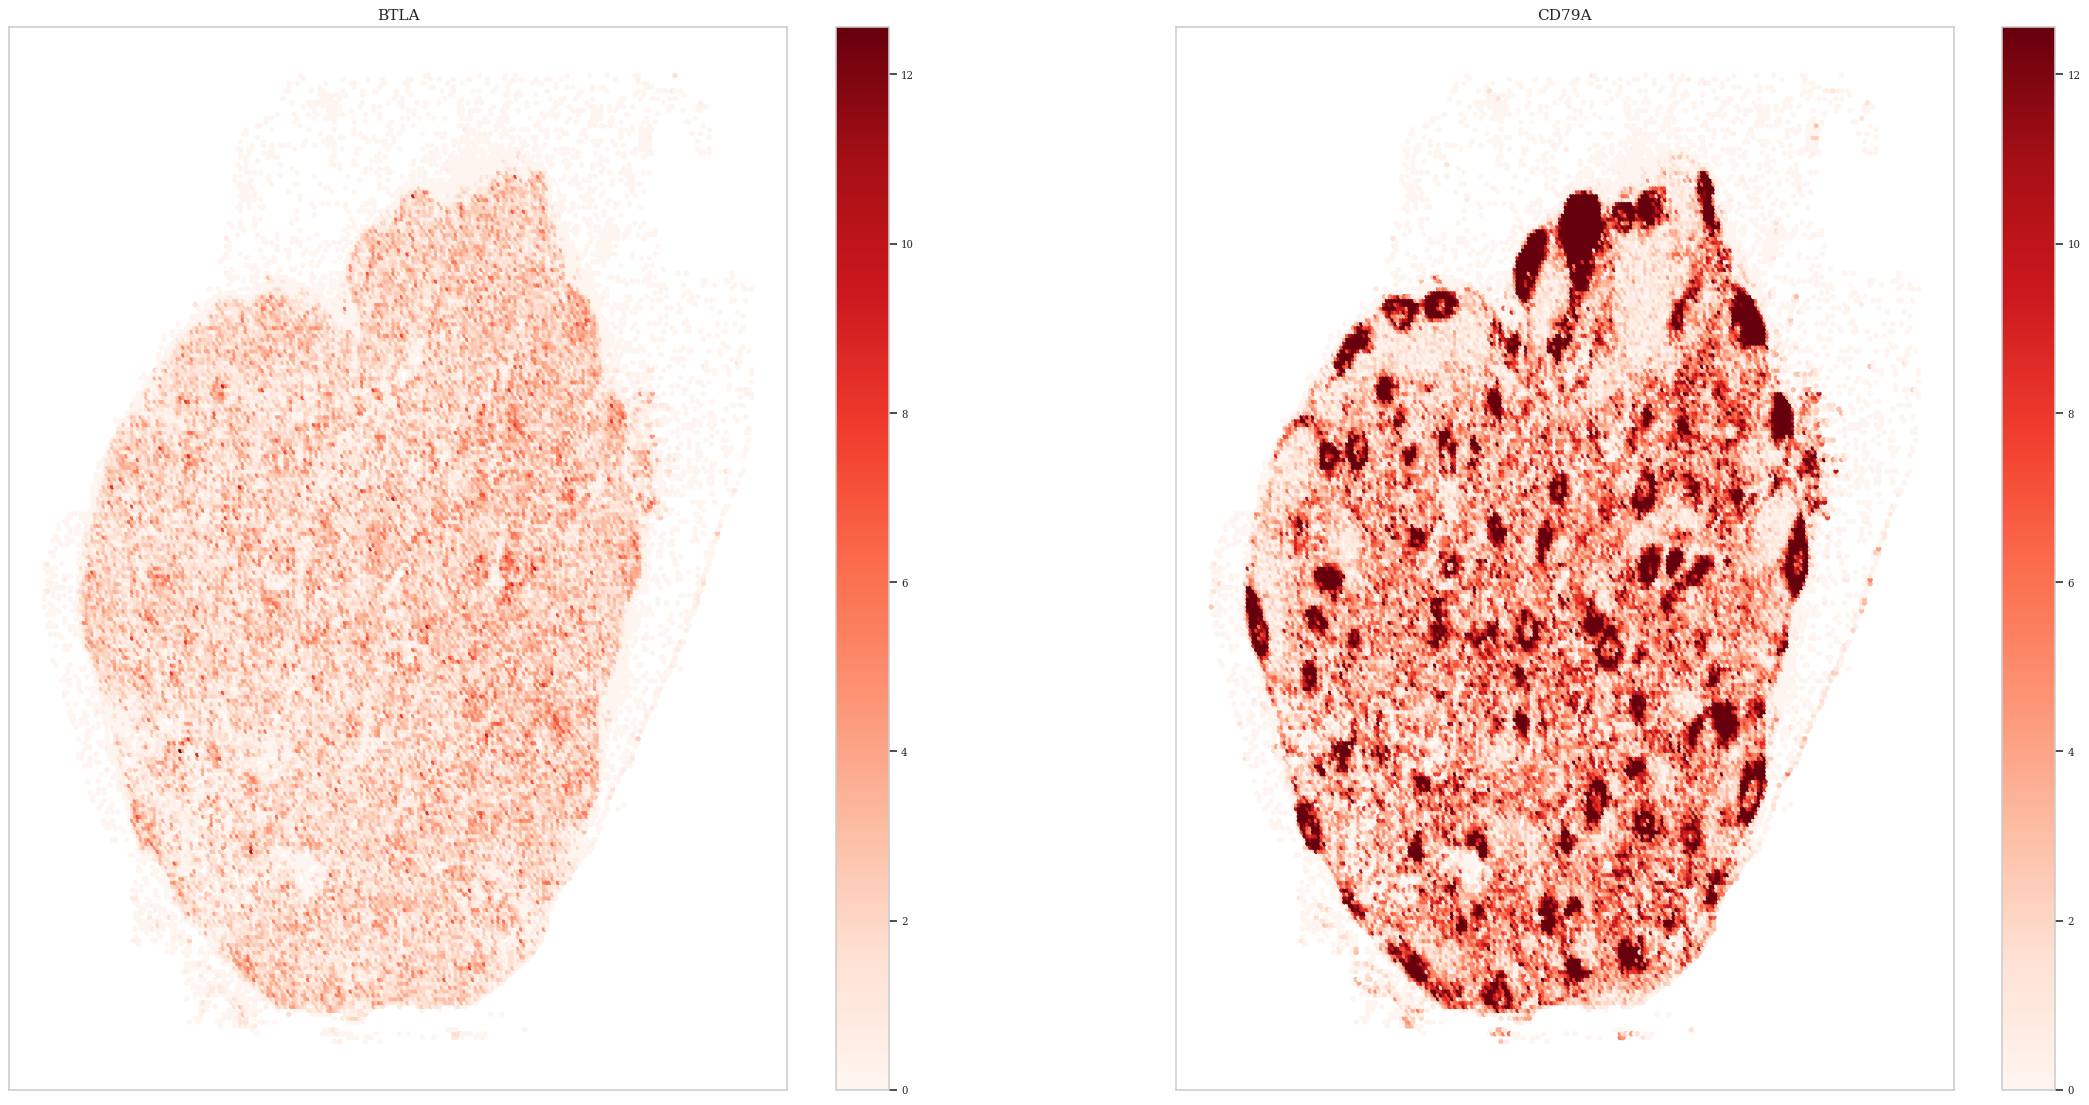

In [229]:
from matplotlib.colors import ListedColormap,Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
palette = sns.color_palette("Reds", as_cmap=True)
listed_cmap = ListedColormap(palette(np.linspace(0, 1, 256)))

norm = Normalize(vmin=ligand_values.min(), vmax=ligand_values.max())
sc = axes[0].scatter(x=x, y=y, c=ligand_values, cmap=listed_cmap, norm=norm, s=10)
sc = axes[1].scatter(x=x, y=y, c=receptor_values, cmap=listed_cmap, norm=norm, s=10)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

axes[0].set_title('BTLA')
axes[1].set_title('CD79A')

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=listed_cmap), ax=axes[0])
cbar.ax.set_xlabel("", labelpad=10)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.label.set_size(10)  # Reduce label font size
cbar.ax.tick_params(labelsize=8) 

cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=listed_cmap), ax=axes[1])
cbar.ax.set_xlabel("", labelpad=10)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.label.set_size(10)  # Reduce label font size
cbar.ax.tick_params(labelsize=8) 


<center> Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers

In [ ]:
np.random.seed(12345)
import esda